# SPY Options Sentiment & Volatility Project
# Team: (>^_^)> CoreX <(^_^<)

#### Importing the needed libraries:

In [26]:
import pyspark
#import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType
from pyspark.sql.functions import col, column, year, when, expr, split, array_contains
from pyspark.sql.window import Window

from pyspark.sql import Row
from pyspark.mllib.recommendation import ALS
from pyspark.sql.types import StructType, StructField, FloatType, IntegerType, StringType, DateType, LongType
from pyspark.sql import functions as F

#for the regression model:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.sql.functions import mean
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline



## 1. Pipeline and Data Processing Part:

#### We created a SparkSession to read, clean, and analyze data.

In [2]:
#create a spark session rather than spark context in order to use dataframe
ss=SparkSession.builder.appName("ClusterFinal").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/23 23:08:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Set the directory directory to ~/scratch where Spark stores temporary checkpoint files and then delete them to prevent our storage from getting full.

In [3]:
ss.sparkContext.setCheckpointDir("~/scratch")

#### We defined a schema for the options dataset to specify each column’s name and data type, ensuring Spark reads the file correctly and treats numeric and date values properly.

In [4]:
options_schema = StructType([
    StructField("QUOTE_UNIXTIME", LongType(), True),
    StructField("QUOTE_READTIME", StringType(), True),
    StructField("QUOTE_DATE", DateType(), True),
    StructField("QUOTE_TIME_HOURS", FloatType(), True),
    StructField("UNDERLYING_LAST", FloatType(), True),
    StructField("EXPIRE_DATE", DateType(), True),
    StructField("EXPIRE_UNIX", StringType(), True),
    StructField("DTE", FloatType(), True),

    # Call option features
    StructField("C_DELTA", FloatType(), True),
    StructField("C_GAMMA", FloatType(), True),
    StructField("C_VEGA", FloatType(), True),
    StructField("C_THETA", FloatType(), True),
    StructField("C_RHO", FloatType(), True),
    StructField("C_IV", FloatType(), True),
    StructField("C_VOLUME", FloatType(), True),
    StructField("C_LAST", FloatType(), True),
    StructField("C_SIZE", StringType(), True),
    StructField("C_BID", FloatType(), True),
    StructField("C_ASK", FloatType(), True),
    
    StructField("STRIKE", FloatType(), True),
    # Put option features
    StructField("P_BID", FloatType(), True),
    StructField("P_ASK", FloatType(), True),
    StructField("P_SIZE", StringType(), True),
    StructField("P_LAST", FloatType(), True),
    StructField("P_DELTA", FloatType(), True),
    StructField("P_GAMMA", FloatType(), True),
    StructField("P_VEGA", FloatType(), True),
    StructField("P_THETA", FloatType(), True),
    StructField("P_RHO", FloatType(), True),
    StructField("P_IV", FloatType(), True),
    StructField("P_VOLUME", FloatType(), True),

    
    StructField("STRIKE_DISTANCE", FloatType(), True),
    StructField("STRIKE_DISTANCE_PCT", FloatType(), True)
])

#### We loaded the SPY options dataset using the predefined schema so Spark reads each column with the correct data type and structure.

In [5]:
df = ss.read.csv("spy_2020_2022.csv", schema=options_schema, header=True, inferSchema=False) # Make sure to use the small dataset

### checking the total number of rows ###
#df.count()

3589079

In [6]:
### to display the dataset’s structure and confirm columns ###
#options_DF.printSchema()

#### Cleaning the data by converting dates, removing missing values, and filtering out negative prices

In [7]:
cleaned_df = df.withColumn("Quote_DATE", F.to_date("Quote_DATE")) #converting Quote_DATE column from string to date formate
cleaned_df = cleaned_df.dropna(subset=["QUOTE_DATE", "C_BID", "C_ASK", "P_BID", "P_ASK", "C_VOLUME", "P_VOLUME"]) #removed any NA values
cleaned_df = cleaned_df.filter((F.col("C_BID") >= 0) & (F.col("C_ASK") >= 0) & (F.col("P_BID") >= 0) & (F.col("P_ASK") >= 0)) #Filtered out invalid option quotes where prices are negative

cleaned_df = cleaned_df.withColumn("Year", F.year("QUOTE_DATE"))
cleaned_df = cleaned_df.withColumn("Month", F.month("QUOTE_DATE"))

### checking the total number of rows ###
#cleaned_df.count()

25/11/23 23:08:27 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header:  [QUOTE_DATE],  [C_VOLUME],  [C_BID],  [C_ASK],  [P_BID],  [P_ASK],  [P_VOLUME]
 Schema: QUOTE_DATE, C_VOLUME, C_BID, C_ASK, P_BID, P_ASK, P_VOLUME
Expected: QUOTE_DATE but found:  [QUOTE_DATE]
CSV file: file:///storage/work/hba5282/GP1/spy_2020_2022.csv


2308838

In [8]:
### create a smaller sample that have 3% of the data (~100,000 rows) for testing
#sample_df = cleaned_df.sample(withReplacement=False, fraction=0.03, seed=42)

#### Saving the sampled dataset as options_sample.csv

In [9]:
# saving the small test dataset
# coalesce(1) is used to save one file only
#sample_df.coalesce(1).write.mode("overwrite").csv("spy_small_sample", header=True)

25/11/23 23:09:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/11/23 23:09:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: [QUOTE_UNIXTIME],  [QUOTE_READTIME],  [QUOTE_DATE],  [QUOTE_TIME_HOURS],  [UNDERLYING_LAST],  [EXPIRE_DATE],  [EXPIRE_UNIX],  [DTE],  [C_DELTA],  [C_GAMMA],  [C_VEGA],  [C_THETA],  [C_RHO],  [C_IV],  [C_VOLUME],  [C_LAST],  [C_SIZE],  [C_BID],  [C_ASK],  [STRIKE],  [P_BID],  [P_ASK],  [P_SIZE],  [P_LAST],  [P_DELTA],  [P_GAMMA],  [P_VEGA],  [P_THETA],  [P_RHO],  [P_IV],  [P_VOLUME],  [STRIKE_DISTANCE],  [STRIKE_DISTANCE_PCT]
 Schema: QUOTE_UNIXTIME, QUOTE_READTIME, QUOTE_DATE, QUOTE_TIME_HOURS, UNDERLYING_LAST, EXPIRE_DATE, EXPIRE_UNIX, DTE, C_DELTA, C_GAMMA, C_VEGA, C_THETA, C_RHO, C_IV, C_VOLUME, C_LAST, C_SIZE, C_BID, C_ASK, STRIKE, P_BID, P_ASK, P_SIZE, P_LAST, P_DELTA, P_GAMMA, P_VEGA, P_THETA, P_RHO, P_

#### Reading the sample file we saved earlier
##### we renamed the output from "part-00000" into "option_sample.csv" manually

In [11]:
#options_DF = ss.read.csv("spy_small_sample/option_sample.csv", schema=options_schema, header=True, inferSchema=False)
options_DF = cleaned_df

In [12]:
### Checking the cleaned dataframe ###
#options_DF.printSchema()
#options_DF.show(5)
print("Number of rows:", options_DF.count())

root
 |-- QUOTE_UNIXTIME: long (nullable = true)
 |-- QUOTE_READTIME: string (nullable = true)
 |-- QUOTE_DATE: date (nullable = true)
 |-- QUOTE_TIME_HOURS: float (nullable = true)
 |-- UNDERLYING_LAST: float (nullable = true)
 |-- EXPIRE_DATE: date (nullable = true)
 |-- EXPIRE_UNIX: string (nullable = true)
 |-- DTE: float (nullable = true)
 |-- C_DELTA: float (nullable = true)
 |-- C_GAMMA: float (nullable = true)
 |-- C_VEGA: float (nullable = true)
 |-- C_THETA: float (nullable = true)
 |-- C_RHO: float (nullable = true)
 |-- C_IV: float (nullable = true)
 |-- C_VOLUME: float (nullable = true)
 |-- C_LAST: float (nullable = true)
 |-- C_SIZE: string (nullable = true)
 |-- C_BID: float (nullable = true)
 |-- C_ASK: float (nullable = true)
 |-- STRIKE: float (nullable = true)
 |-- P_BID: float (nullable = true)
 |-- P_ASK: float (nullable = true)
 |-- P_SIZE: string (nullable = true)
 |-- P_LAST: float (nullable = true)
 |-- P_DELTA: float (nullable = true)
 |-- P_GAMMA: float (nul

25/11/23 23:12:43 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 35, schema size: 33
CSV file: file:///storage/work/hba5282/GP1/spy_small_sample/option_sample.csv


+--------------+----------------+----------+----------------+---------------+-----------+-----------+---+-------+-------+-------+--------+-------+-------+--------+------+----------+------+------+------+-----+-----+--------+------+--------+-------+-------+--------+--------+-------+--------+---------------+-------------------+
|QUOTE_UNIXTIME|  QUOTE_READTIME|QUOTE_DATE|QUOTE_TIME_HOURS|UNDERLYING_LAST|EXPIRE_DATE|EXPIRE_UNIX|DTE|C_DELTA|C_GAMMA| C_VEGA| C_THETA|  C_RHO|   C_IV|C_VOLUME|C_LAST|    C_SIZE| C_BID| C_ASK|STRIKE|P_BID|P_ASK|  P_SIZE|P_LAST| P_DELTA|P_GAMMA| P_VEGA| P_THETA|   P_RHO|   P_IV|P_VOLUME|STRIKE_DISTANCE|STRIKE_DISTANCE_PCT|
+--------------+----------------+----------+----------------+---------------+-----------+-----------+---+-------+-------+-------+--------+-------+-------+--------+------+----------+------+------+------+-----+-----+--------+------+--------+-------+-------+--------+--------+-------+--------+---------------+-------------------+
|    1630526400|202

#### Calculating the Put-Call Ratio (PCR) by dividing total put volume by total call volume — a key indicator of overall market sentiment for each day

In [13]:
# There exist days that are equal to ZERO, code adjusted to safely compute Put-Call Ratio (PCR) and avoid divide-by-zero errors
pcr_df = options_DF.groupBy("QUOTE_DATE").agg(
    F.when(F.sum("C_VOLUME") != 0,
           F.sum("P_VOLUME") / F.sum("C_VOLUME"))
     .otherwise(None)
     .alias("Put_Call_Ratio")
)

#pcr_df.show()

+----------+-------------------+
|QUOTE_DATE|     Put_Call_Ratio|
+----------+-------------------+
|2021-08-27|  3.552747791952895|
|2020-08-24| 0.9376427191287546|
|2022-03-28| 2.9026821498304387|
|2021-06-22| 0.6602779424356188|
|2021-10-11|0.32622154915148543|
|2021-01-27| 1.6430612096245518|
|2022-08-02|  0.595874497882966|
|2020-08-05| 1.7949704901206056|
|2022-07-27| 0.6632060020077138|
|2022-11-29|0.24928515726540162|
|2020-07-24| 1.4819084213896894|
|2020-01-21| 2.9231512808119864|
|2020-08-28| 1.6173054587688733|
|2020-04-30| 1.0827515400410677|
|2022-05-19| 0.5232248647720443|
|2022-01-31|  2.044699195607148|
|2021-09-14| 3.5880135331077816|
|2022-06-22|0.21945265321855326|
|2022-05-26| 3.0552356459998884|
|2021-07-20| 0.9526971165464698|
+----------+-------------------+
only showing top 20 rows


#### Estimating the implied volatility proxy (IV_Proxy) by measuring the relative bid–ask spread of call options — a wider spread suggests higher uncertainty.

#### Then we averaged this proxy by date to track daily market volatility sentiment.

In [14]:
# Calculate the average of bid and ask to represent the fair market value
iv_df = options_DF.withColumn("MidPrice", (F.col("C_ASK") + F.col("C_BID")) / 2)

# Estimate the implied volatility proxy (a measure of uncertainty)
iv_df = iv_df.withColumn("IV_proxy", F.when(F.col("MidPrice") != 0, (F.col("C_ASK") - F.col("C_BID")) / F.col("MidPrice")).otherwise(None))

# Compute the daily average IV proxy to summarize market volatility sentiment by day
iv_df = iv_df.groupBy("Quote_DATE").agg(F.avg("IV_proxy").alias("IV_Proxy"))

# Show a few rows to verify the results
#iv_df.show()

+----------+--------------------+
|Quote_DATE|            IV_Proxy|
+----------+--------------------+
|2021-08-27| 0.08153513367723304|
|2020-08-24| 0.05112005386113025|
|2022-03-28|  0.1145061692772024|
|2021-06-22| 0.09368629846067385|
|2021-10-11| 0.11758010716513088|
|2021-01-27| 0.06360324776265239|
|2022-08-02|0.021704873446048323|
|2020-08-05| 0.04869813105937511|
|2022-07-27|0.030816074432390476|
|2022-11-29|  0.1972773546594222|
|2020-07-24|0.052183470026899714|
|2020-01-21|0.014159552656806134|
|2020-08-28| 0.01920237989679674|
|2020-04-30| 0.14725817684091327|
|2022-05-19|  0.3135088362074185|
|2022-01-31| 0.13424057964373878|
|2021-09-14| 0.24139776411134745|
|2022-06-22| 0.21040894642058308|
|2022-05-26| 0.20511890615272174|
|2021-07-20| 0.07740904116677418|
+----------+--------------------+
only showing top 20 rows


#### Splitting values like "10x5" and converting them into numeric totals

In [15]:
# Split the option size columns into separate parts (e.g., "10x5" → ["10", "5"])
options_DF = options_DF.withColumn("C_SIZE_SPL", F.split(F.col("C_SIZE"), "x")) \
       .withColumn("P_SIZE_SPL", F.split(F.col("P_SIZE"), "x"))

# Convert call size strings into numeric values by multiplying split parts if needed
options_DF = options_DF.withColumn(
    "C_SIZE_NUM",
    F.when(F.size("C_SIZE_SPL") == 2,
           F.col("C_SIZE_SPL").getItem(0).cast("int") * F.col("C_SIZE_SPL").getItem(1).cast("int")
          ).otherwise(F.col("C_SIZE_SPL").getItem(0).cast("int"))
)

# Convert put size strings into numeric values using the same logic
options_DF = options_DF.withColumn(
    "P_SIZE_NUM",
    F.when(F.size("P_SIZE_SPL") == 2,
           F.col("P_SIZE_SPL").getItem(0).cast("int") * F.col("P_SIZE_SPL").getItem(1).cast("int")
          ).otherwise(F.col("P_SIZE_SPL").getItem(0).cast("int"))
)

#### We defined large trades using the 95th percentile of trade size and calculated the daily ratio of large trades to total trades as a measure of big-investor activity.

In [16]:
threshold = options_DF.approxQuantile("C_SIZE_NUM", [0.95], 0.01)[0]

options_DF = options_DF.withColumn(
    "IsLargeTrade",
    F.when((F.col("C_SIZE_NUM") > threshold) | (F.col("P_SIZE_NUM") > threshold), 1).otherwise(0))

# Same issue with days equal to ZERO. code adjusted to safely compute Large Trade Frequency Ratio (LTF_Ratio)
ltf_df = options_DF.groupBy("QUOTE_DATE").agg(
    F.when(F.count("*") != 0,
           F.sum("IsLargeTrade") / F.count("*"))
     .otherwise(None)
     .alias("LTF_Ratio"))

#ltf_df.show()

+----------+-------------------+
|QUOTE_DATE|          LTF_Ratio|
+----------+-------------------+
|2021-08-27| 0.1509433962264151|
|2020-08-24| 0.3409090909090909|
|2022-03-28|  0.136986301369863|
|2021-06-22|0.24107142857142858|
|2021-10-11|0.11224489795918367|
|2021-01-27|0.06976744186046512|
|2022-08-02| 0.1694915254237288|
|2020-08-05|0.27692307692307694|
|2022-07-27|0.10144927536231885|
|2022-11-29| 0.2727272727272727|
|2020-07-24|              0.225|
|2020-01-21|0.39655172413793105|
|2020-08-28| 0.2328767123287671|
|2020-04-30|0.07142857142857142|
|2022-05-19|0.10416666666666667|
|2022-01-31|0.02197802197802198|
|2021-09-14|0.12037037037037036|
|2022-06-22|0.25252525252525254|
|2022-05-26|0.11578947368421053|
|2021-07-20|  0.102803738317757|
+----------+-------------------+
only showing top 20 rows


#### We combined all daily sentiment metrics into one DataFrame by joining on the date column, creating a single dataset ready for analysis or visualization.

In [17]:
result_df = pcr_df.join(iv_df, "QUOTE_DATE", "inner").join(ltf_df, "QUOTE_DATE", "inner")
result_df = result_df.orderBy("QUOTE_DATE")

#result_df.show()

+----------+------------------+--------------------+-------------------+
|QUOTE_DATE|    Put_Call_Ratio|            IV_Proxy|          LTF_Ratio|
+----------+------------------+--------------------+-------------------+
|2020-01-02|0.6531658549089977|  0.1145452464502475| 0.3787878787878788|
|2020-01-03|1.1738391845979614| 0.07274764128013915| 0.2112676056338028|
|2020-01-06|2.4168987929433614| 0.17957390713610255| 0.2786885245901639|
|2020-01-07|0.7379826635145784| 0.08571076286408325| 0.3013698630136986|
|2020-01-08|0.7982155113246396| 0.08591771425337316|0.23809523809523808|
|2020-01-09|2.1481481481481484| 0.12668727646620392| 0.3918918918918919|
|2020-01-10| 2.294067067927773| 0.11235427190488252|0.29508196721311475|
|2020-01-13|1.1577799321376636|0.015542844610804126| 0.3924050632911392|
|2020-01-14|0.9142945544554455|0.040089792115158986|0.35384615384615387|
|2020-01-15|0.9679210363972857|  0.0934305779155185|0.19607843137254902|
|2020-01-16|1.7944969905417025| 0.12533069915667255

#### We added a Market_Phase column that labels each date as “Pandemic,” “Optimism,” or “Correction” based on the year to categorize market sentiment periods.

In [18]:
result_df = result_df.withColumn(
    "Market_Phase",
    F.when((F.col("QUOTE_DATE") >= F.lit("2020-01-01")) & (F.col("QUOTE_DATE") <= F.lit("2020-12-31")), "Pandemic")
     .when((F.col("QUOTE_DATE") >= F.lit("2021-01-01")) & (F.col("QUOTE_DATE") <= F.lit("2021-12-31")), "Optimism")
     .when((F.col("QUOTE_DATE") >= F.lit("2022-01-01")) & (F.col("QUOTE_DATE") <= F.lit("2022-12-31")), "Correction")
     .otherwise("Other")
)

result_df = result_df.orderBy("QUOTE_DATE")
#result_df.show()

+----------+------------------+--------------------+-------------------+------------+
|QUOTE_DATE|    Put_Call_Ratio|            IV_Proxy|          LTF_Ratio|Market_Phase|
+----------+------------------+--------------------+-------------------+------------+
|2020-01-02|0.6531658549089977|  0.1145452464502475| 0.3787878787878788|    Pandemic|
|2020-01-03|1.1738391845979614| 0.07274764128013915| 0.2112676056338028|    Pandemic|
|2020-01-06|2.4168987929433614| 0.17957390713610255| 0.2786885245901639|    Pandemic|
|2020-01-07|0.7379826635145784| 0.08571076286408325| 0.3013698630136986|    Pandemic|
|2020-01-08|0.7982155113246396| 0.08591771425337316|0.23809523809523808|    Pandemic|
|2020-01-09|2.1481481481481484| 0.12668727646620392| 0.3918918918918919|    Pandemic|
|2020-01-10| 2.294067067927773| 0.11235427190488252|0.29508196721311475|    Pandemic|
|2020-01-13|1.1577799321376636|0.015542844610804126| 0.3924050632911392|    Pandemic|
|2020-01-14|0.9142945544554455|0.040089792115158986|0.

In [ ]:
result_df.select("QUOTE_DATE", "Put_Call_Ratio", "IV_Proxy", "LTF_Ratio", "Market_Phase").write.mode("overwrite").option("header", True).csv("/storage/home/xqm5143/work/FinalProject/daily_sentiment")

#### We merge our daily sentiment metrics (PCR, IV_Proxy, LTF_Ratio, Market_Phase) back onto the full option-level dataset so every option record is enriched with the corresponding daily market signals.

In [19]:
full_df = options_DF.join(result_df, "QUOTE_DATE", "left")
#full_df.show(5)

+----------+--------------+----------------+----------------+---------------+-----------+-----------+---+-------+-------+-------+--------+-------+-------+--------+------+----------+------+------+------+-----+-----+--------+------+--------+-------+-------+--------+--------+-------+--------+---------------+-------------------+-------------+-----------+----------+----------+------------+------------------+-------------------+------------------+------------+
|QUOTE_DATE|QUOTE_UNIXTIME|  QUOTE_READTIME|QUOTE_TIME_HOURS|UNDERLYING_LAST|EXPIRE_DATE|EXPIRE_UNIX|DTE|C_DELTA|C_GAMMA| C_VEGA| C_THETA|  C_RHO|   C_IV|C_VOLUME|C_LAST|    C_SIZE| C_BID| C_ASK|STRIKE|P_BID|P_ASK|  P_SIZE|P_LAST| P_DELTA|P_GAMMA| P_VEGA| P_THETA|   P_RHO|   P_IV|P_VOLUME|STRIKE_DISTANCE|STRIKE_DISTANCE_PCT|   C_SIZE_SPL| P_SIZE_SPL|C_SIZE_NUM|P_SIZE_NUM|IsLargeTrade|    Put_Call_Ratio|           IV_Proxy|         LTF_Ratio|Market_Phase|
+----------+--------------+----------------+----------------+---------------+-----

25/11/23 23:13:02 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 35, schema size: 33
CSV file: file:///storage/work/hba5282/GP1/spy_small_sample/option_sample.csv


#### Then we save the final DataFrame as a CSV file for future use.

In [20]:
# full_df_pd = full_df.toPandas()
# # full_df_pd.to_csv("SPY_sample1_cleaData2.csv", index=False)
# full_df_pd.to_csv("SPY_cleaData2.csv", index=False)

25/11/23 23:13:04 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 35, schema size: 33
CSV file: file:///storage/work/hba5282/GP1/spy_small_sample/option_sample.csv


## 2. Exploring and Analyzing Our Data + Modeling

#### Loading our sampled and cleaned data

In [21]:
# #full_df_pd = pd.read_csv("SPY_sample1_cleaData2.csv", parse_dates=["QUOTE_DATE"])
# full_df_pd = pd.read_csv("SPY_cleaData2.csv", parse_dates=["QUOTE_DATE"])


# print(full_df_pd.shape)          # number of rows and columns
# print(full_df_pd.dtypes)         # data types for each column
# #full_df_pd.head()                # show first few rows

(68992, 42)
QUOTE_DATE             datetime64[ns]
QUOTE_UNIXTIME                  int64
QUOTE_READTIME                 object
QUOTE_TIME_HOURS              float64
UNDERLYING_LAST               float64
EXPIRE_DATE                    object
EXPIRE_UNIX                     int64
DTE                           float64
C_DELTA                       float64
C_GAMMA                       float64
C_VEGA                        float64
C_THETA                       float64
C_RHO                         float64
C_IV                          float64
C_VOLUME                      float64
C_LAST                        float64
C_SIZE                         object
C_BID                         float64
C_ASK                         float64
STRIKE                        float64
P_BID                         float64
P_ASK                         float64
P_SIZE                         object
P_LAST                        float64
P_DELTA                       float64
P_GAMMA                       float64


,QUOTE_DATE,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,STRIKE_DISTANCE_PCT,C_SIZE_SPL,P_SIZE_SPL,C_SIZE_NUM,P_SIZE_NUM,IsLargeTrade,Put_Call_Ratio,IV_Proxy,LTF_Ratio,Market_Phase
0,2021-09-01,1630526400,2021-09-01 16:00,16.0,451.85,2021-09-01,1630526400,0.0,1.00000,0.00000,...,0.170,"['1 ', ' 1']","['0 ', ' 2679']",1,0,0,0.948703,0.080282,0.172414,Optimism
1,2021-09-01,1630526400,2021-09-01 16:00,16.0,451.85,2021-09-03,1630699200,2.0,1.00000,0.00000,...,0.436,"['97 ', ' 102']","['0 ', ' 5766']",9894,0,0,0.948703,0.080282,0.172414,Optimism
2,2021-09-01,1630526400,2021-09-01 16:00,16.0,451.85,2021-09-03,1630699200,2.0,1.00000,0.00000,...,0.336,"['200 ', ' 200']","['0 ', ' 4216']",40000,0,0,0.948703,0.080282,0.172414,Optimism
3,2021-09-01,1630526400,2021-09-01 16:00,16.0,451.85,2021-09-03,1630699200,2.0,0.06422,0.04607,...,0.009,"['2597 ', ' 832']","['10 ', ' 10']",2160704,100,1,0.948703,0.080282,0.172414,Optimism
4,2021-09-01,1630526400,2021-09-01 16:00,16.0,451.85,2021-09-03,1630699200,2.0,0.00290,0.00107,...,0.045,"['0 ', ' 6166']","['150 ', ' 1']",0,150,0,0.948703,0.080282,0.172414,Optimism


#### Viewing summary statistics

In [22]:
# full_df_pd[["Put_Call_Ratio", "IV_Proxy", "LTF_Ratio"]].describe()

,Put_Call_Ratio,IV_Proxy,LTF_Ratio
count,68911.000000,68992.000000,68992.000000
mean,1.811687,0.128705,0.162801
std,1.365845,0.087961,0.096647
min,0.159266,0.006686,0.000000
25%,0.939223,0.068733,0.095238
50%,1.459595,0.108533,0.153846
75%,2.222825,0.158599,0.221239
max,13.475355,0.681775,0.623188


#### Summarizing by market phase shows how each sentiment metric behaves in different market periods (Pandemic, Optimism, Correction).

In [23]:
# phase_summary = full_df_pd.groupby("Market_Phase")[["Put_Call_Ratio", "IV_Proxy", "LTF_Ratio"]].agg(["mean", "std", "min", "max"])
# phase_summary

Put_Call_Ratio                                 IV_Proxy  \
                       mean       std       min        max      mean   
Market_Phase                                                           
Correction         1.908768  1.676363  0.159266  13.475355  0.175954   
Optimism           1.961492  1.464607  0.171782   7.742904  0.103666   
Pandemic           1.544010  0.713727  0.381713   8.178414  0.110914   

                                           LTF_Ratio                     \
                   std       min       max      mean       std      min   
Market_Phase                                                              
Correction    0.086631  0.021705  0.431648  0.167066  0.099080  0.00000   
Optimism      0.043509  0.017636  0.272855  0.145048  0.064397  0.00885   
Pandemic      0.107003  0.006686  0.681775  0.179016  0.119173  0.00000   

                        
                   max  
Market_Phase            
Correction    0.417910  
Optimism      0.326923  
Pandemic      0.623188

#### We look at the correlations to check whether high put-call ratios are associated with higher implied volatility or large trade activity.

In [24]:
# corr = full_df_pd[["Put_Call_Ratio", "IV_Proxy", "LTF_Ratio"]].corr()
# corr

,Put_Call_Ratio,IV_Proxy,LTF_Ratio
Put_Call_Ratio,1.000000,-0.10514,0.076847
IV_Proxy,-0.105140,1.00000,-0.296660
LTF_Ratio,0.076847,-0.29666,1.000000


#### Creating a time series plots by date and phase

##### These plots will show us how volatility and sentiment shifted during different phases.

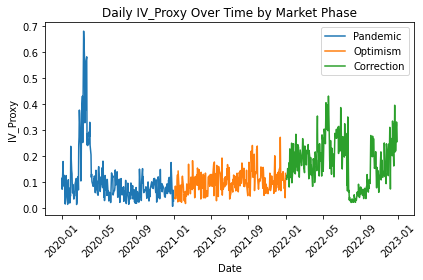

In [28]:
# full_df_pd = full_df_pd.sort_values("QUOTE_DATE")

# for phase in full_df_pd["Market_Phase"].unique():
#     subset = full_df_pd[full_df_pd["Market_Phase"] == phase]
#     plt.plot(
#         subset["QUOTE_DATE"].to_numpy(),   # or .values
#         subset["IV_Proxy"].to_numpy(),     # or .values
#         label=phase
#     )

# plt.title("Daily IV_Proxy Over Time by Market Phase")
# plt.xlabel("Date")
# plt.ylabel("IV_Proxy")
# plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()


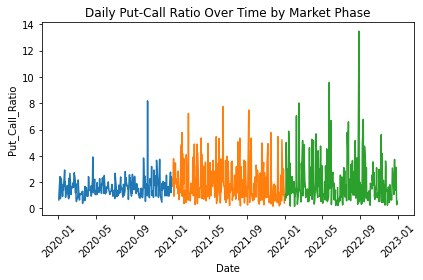

In [30]:
# for phase in full_df_pd["Market_Phase"].unique():
#     subset = full_df_pd[full_df_pd["Market_Phase"] == phase]
#     plt.plot(
#         subset["QUOTE_DATE"].to_numpy(),   # or .values
#         subset["Put_Call_Ratio"].to_numpy(),     # or .values
#         label=phase
#     )
    
# # Put-Call Ratio over time
# plt.title("Daily Put-Call Ratio Over Time by Market Phase")
# plt.xlabel("Date")
# plt.ylabel("Put_Call_Ratio")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

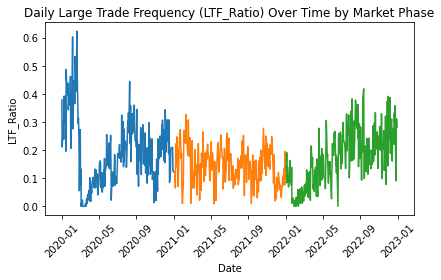

In [31]:
# for phase in full_df_pd["Market_Phase"].unique():
#     subset = full_df_pd[full_df_pd["Market_Phase"] == phase]
#     plt.plot(
#         subset["QUOTE_DATE"].to_numpy(),   # or .values
#         subset["LTF_Ratio"].to_numpy(),     # or .values
#         label=phase
#     )

# # Large Trade Frequency over time
# plt.title("Daily Large Trade Frequency (LTF_Ratio) Over Time by Market Phase")
# plt.xlabel("Date")
# plt.ylabel("LTF_Ratio")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()
#.coalesce(1)

##### Extra plots (Boxplot), if needed, to see how each metric’s range and median differ between market regimes.

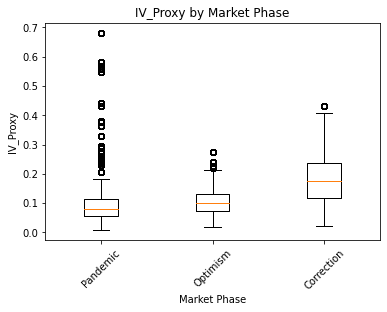

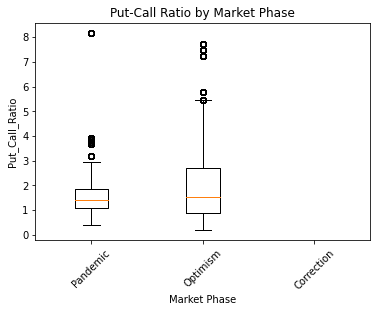

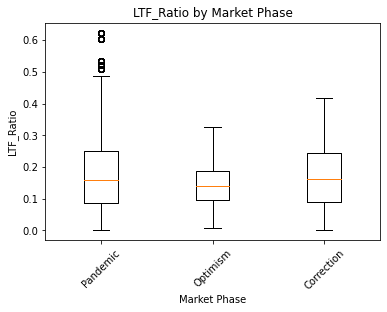

In [32]:
# # IV_Proxy by phase
# phases = full_df_pd["Market_Phase"].unique()
# data = [full_df_pd[full_df_pd["Market_Phase"] == phase]["IV_Proxy"] for phase in phases]
# plt.boxplot(data, labels=phases)
# plt.title("IV_Proxy by Market Phase")
# plt.xlabel("Market Phase")
# plt.ylabel("IV_Proxy")
# plt.xticks(rotation=45)
# plt.show()

# # Put_Call_Ratio by phase
# data = [full_df_pd[full_df_pd["Market_Phase"] == phase]["Put_Call_Ratio"] for phase in phases]
# plt.boxplot(data, labels=phases)
# plt.title("Put-Call Ratio by Market Phase")
# plt.xlabel("Market Phase")
# plt.ylabel("Put_Call_Ratio")
# plt.xticks(rotation=45)
# plt.show()

# # LTF_Ratio by phase
# data = [full_df_pd[full_df_pd["Market_Phase"] == phase]["LTF_Ratio"] for phase in phases]
# plt.boxplot(data, labels=phases)
# plt.title("LTF_Ratio by Market Phase")
# plt.xlabel("Market Phase")
# plt.ylabel("LTF_Ratio")
# plt.xticks(rotation=45)
# plt.show()

#### A simple regression model to see if we can predict volatility (IV_Proxy)

In [33]:
# # Drop rows with missing values in model columns
# model_df = full_df.dropna(subset=["IV_Proxy", "Put_Call_Ratio", "LTF_Ratio"])

# # Define predictors and target
# X = model_df[["Put_Call_Ratio", "LTF_Ratio"]]
# y = model_df["IV_Proxy"]

# # Split data for evaluation
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train linear regression model
# lr = LinearRegression()
# lr.fit(X_train, y_train)

# # Predict and evaluate
# y_pred = lr.predict(X_test)
# r2 = r2_score(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# print("R²:", round(r2, 3))
# print("RMSE:", round(rmse, 3))
# print("Coefficients:", lr.coef_)
# print("Intercept:", lr.intercept_)


R²: 0.087
RMSE: 0.084
Coefficients: [-0.00546187 -0.26343696]
Intercept: 0.1812617500572831


## 3. Preforming PCA (Principal Component Analysis) and finding KMeans

we selected three sentiment indicators (Put_Call_Ratio, IV_Proxy, LTF_Ratio) as input variables for modeling

In [34]:
feature_columns = ["Put_Call_Ratio", "IV_Proxy", "LTF_Ratio"]

In [35]:
modelData = full_df
modelData = modelData.dropna(subset=["Put_Call_Ratio", "IV_Proxy", "LTF_Ratio"])
assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features")

assembled_data = assembler.transform(modelData)

We standardize the data with StandardScaler to remove unit bias before PCA

In [36]:
scaler = StandardScaler(inputCol="features",
                        outputCol="scaled_features",
                        withStd=True,
                        withMean=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

In [37]:
# PCA
pca = PCA(k=3, inputCol="scaled_features", outputCol="pcaFeatures")
model = pca.fit(scaled_data)
result = model.transform(scaled_data)

explained_variance = model.explainedVariance
print("Explained Variance: ", sum(explained_variance))

25/11/23 23:17:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/11/23 23:17:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Explained Variance:  1.0


In [38]:
#KMeans

def fit_kmeans(df_input,column_name='pcaFeatures',num_cluster_centers=3):
    kmeans = KMeans(featuresCol=column_name).setK(num_cluster_centers).setSeed(1)
    model = kmeans.fit(df_input)
    clustered_data = model.transform(df_input)
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(clustered_data)
    wcss = model.summary.trainingCost
    cluster_sizes = clustered_data.groupBy("prediction").count()
    # cluster_sizes.show()
    return clustered_data, silhouette_score, wcss

+----------+-----+
|prediction|count|
+----------+-----+
|         1|31646|
|         0|37265|
+----------+-----+

K = 2, silhouette = 0.02, WCSS = 155699.02


+----------+-----+
|prediction|count|
+----------+-----+
|         1|36925|
|         2|12530|
|         0|19456|
+----------+-----+

K = 3, silhouette = 0.04, WCSS = 122615.87


+----------+-----+
|prediction|count|
+----------+-----+
|         1|31400|
|         3| 9124|
|         2|11191|
|         0|17196|
+----------+-----+

K = 4, silhouette = 0.07, WCSS = 89303.62


+----------+-----+
|prediction|count|
+----------+-----+
|         1| 9392|
|         3|29437|
|         4| 2622|
|         2|10838|
|         0|16622|
+----------+-----+

K = 5, silhouette = 0.10, WCSS = 80974.42


+----------+-----+
|prediction|count|
+----------+-----+
|         1| 6645|
|         3| 5276|
|         5| 8512|
|         4|22465|
|         2| 6050|
|         0|19963|
+----------+-----+

K = 6, silhouette = -0.06, WCSS = 69289.05


+----------+-----+
|prediction|count|
+----------+-----+
|         1| 9111|
|         6| 1244|
|         3|27582|
|         5| 9331|
|         4| 2237|
|         2| 5441|
|         0|13965|
+----------+-----+

K = 7, silhouette = -0.10, WCSS = 62616.00


+----------+-----+
|prediction|count|
+----------+-----+
|         1| 8388|
|         6|16498|
|         3| 7638|
|         5| 1152|
|         4| 7434|
|         7|18137|
|         2| 3431|
|         0| 6233|
+----------+-----+

K = 8, silhouette = -0.23, WCSS = 58650.91


+----------+-----+
|prediction|count|
+----------+-----+
|         1| 3809|
|         6|12077|
|         3| 4607|
|         5| 1152|
|         4|10227|
|         8|16223|
|         7| 7299|
|         2| 5976|
|         0| 7541|
+----------+-----+

K = 9, silhouette = -0.13, WCSS = 51003.11


+----------+-----+
|prediction|count|
+----------+-----+
|         1| 6010|
|         6| 3853|
|         3| 6093|
|         5|  789|
|         9|12509|
|         4| 6174|
|         8| 2083|
|         7|12039|
|         2|14797|
|         0| 4564|
+----------+-----+

K = 10, silhouette = -0.16, WCSS = 46702.46


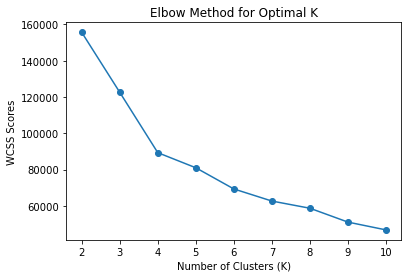

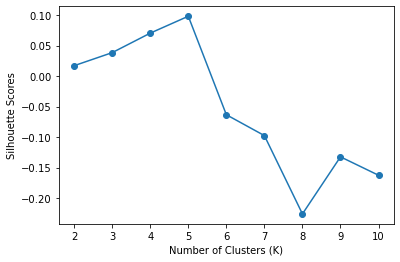

In [39]:
k_values = range(2, 11) 
silhouette_scores = []
wcss_scores = []

for k in k_values:
    clustered_data, silh, wcss = fit_kmeans(result,column_name='pcaFeatures',num_cluster_centers=k)
    silhouette_scores.append(silh)
    wcss_scores.append(wcss)
    print(f"K = {k}, silhouette = {silh:.2f}, WCSS = {wcss:.2f}")
    
    
# plt.plot(k_values, wcss_scores, marker='o')
# plt.title("Elbow Method for Optimal K")
# plt.xlabel("Number of Clusters (K)")
# plt.ylabel("WCSS Scores")
# plt.show()

# plt.plot(k_values, silhouette_scores, marker='o')
# plt.xlabel("Number of Clusters (K)")
# plt.ylabel("Silhouette Scores")
# plt.show()

With unsupervised learning (PCA + KMeans), we let the data decide how many regimes exist and which days belong to each cluster.
This can show us whether the market behavior actually matches our existing labeled phases or if it will reveal something new.

Using unsupervised learning with PCA and KMeans, we allowed the sentiment data to reveal its own structure without using any year-based labels. The elbow plot shows a large drop in WCSS from K=2 to K=5, after which improvements slow down, while the silhouette scores climb steadily and peak at K=5, indicating this is the most stable and well-separated clustering structure. With five clusters, the model forms one large baseline cluster and several smaller clusters representing different intensities of market stress or speculative activity. This suggests that investor sentiment does not fall neatly into only three regimes (Pandemic, Optimism, Correction), but instead exhibits about five distinct behavioral patterns, ranging from normal trading to high-stress, high-uncertainty conditions. Clusters above K=6 produce negative silhouette values, indicating over-segmentation. Overall, PCA + KMeans reveals a richer regime structure than simple year-based labels, identifying five meaningful sentiment-driven market states hidden in the SPY options data.

In [ ]:
clustered_data.select("QUOTE_DATE", "Put_Call_Ratio", "IV_Proxy", "LTF_Ratio", "prediction").write.mode("overwrite").option("header", True).csv("/storage/home/xqm5143/work/FinalProject/kmeans_clusters")

In [40]:
iv_threshold = modelData.approxQuantile("IV_Proxy", [0.75], 0.01)[0]
modelData = modelData.withColumn(
    "HighStress",
    F.when(col("IV_Proxy") >= iv_threshold, 1).otherwise(0)
)

modelData = modelData.withColumn("Year", F.year(col("QUOTE_DATE")))
train_df = modelData.filter((col("Year") == 2020) | (col("Year") == 2021))
test_df = modelData.filter(col("Year") == 2022)

In [41]:
feature_columns = ["Put_Call_Ratio", "LTF_Ratio"]

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features"
)

train_assembled = assembler.transform(train_df)
test_assembled = assembler.transform(test_df)

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(train_assembled)

train_scaled = scaler_model.transform(train_assembled)
test_scaled = scaler_model.transform(test_assembled)

In [42]:
log_model = LogisticRegression(
    featuresCol = "scaled_features",
    labelCol = "HighStress"
)
log_model = log_model.fit(train_scaled)

In [43]:
predictions = log_model.transform(test_scaled)

predictions.select(
    "QUOTE_DATE",
    "Put_Call_Ratio",
    "LTF_Ratio",
    "HighStress",
    "probability",
    "prediction"
)#.show(10, truncate=False)

+----------+------------------+------------------+----------+----------------------------------------+----------+
|QUOTE_DATE|Put_Call_Ratio    |LTF_Ratio         |HighStress|probability                             |prediction|
+----------+------------------+------------------+----------+----------------------------------------+----------+
|2022-08-01|0.9014584790915451|0.3384615384615385|0         |[0.995443976594894,0.004556023405105969]|0.0       |
|2022-08-01|0.9014584790915451|0.3384615384615385|0         |[0.995443976594894,0.004556023405105969]|0.0       |
|2022-08-01|0.9014584790915451|0.3384615384615385|0         |[0.995443976594894,0.004556023405105969]|0.0       |
|2022-08-01|0.9014584790915451|0.3384615384615385|0         |[0.995443976594894,0.004556023405105969]|0.0       |
|2022-08-01|0.9014584790915451|0.3384615384615385|0         |[0.995443976594894,0.004556023405105969]|0.0       |
|2022-08-01|0.9014584790915451|0.3384615384615385|0         |[0.995443976594894,0.004556

In [ ]:
predictions.select("QUOTE_DATE", "HighStress", "prediction", "probability").write.mode("overwrite").option("header", True).csv("/storage/home/xqm5143/work/FinalProject/rf_predictions")

#### Observation
We created a model using the same variables to predect the market volatility, but the model performance was weak because the sentiment features (PCR and LTF) alone are insufficient to accurately classify high-volatility days.

## 4. Attempting to building a stronger predictive model

In [44]:
iv_threshold = modelData.approxQuantile("IV_Proxy", [0.75], 0.01)[0]

modelData = modelData.withColumn(
    "HighStress",
    when(col("IV_Proxy") >= iv_threshold, 1).otherwise(0))

modelData = modelData.withColumn("Year", year(col("QUOTE_DATE")))
train_df = modelData.filter((col("Year") == 2020) | (col("Year") == 2021))
test_df  = modelData.filter(col("Year") == 2022)

In [45]:
rf_features = [
    "Put_Call_Ratio",
    "LTF_Ratio",
    "DTE",
    "STRIKE_DISTANCE_PCT",
    "C_VEGA",
    "C_GAMMA",
    "C_DELTA",
    "UNDERLYING_LAST"]

assembler = VectorAssembler(
    inputCols=rf_features,
    outputCol="rf_features")

train_rf = assembler.transform(train_df).dropna(subset=rf_features)
test_rf  = assembler.transform(test_df).dropna(subset=rf_features)

In [46]:
rf = RandomForestClassifier(
    featuresCol="rf_features",
    labelCol="HighStress",
    numTrees=300,
    maxDepth=10,
    seed=42
)

rf_model = rf.fit(train_rf)
rf_predictions = rf_model.transform(test_rf)

25/11/23 23:19:04 WARN DAGScheduler: Broadcasting large task binary with size 1562.7 KiB
25/11/23 23:19:10 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
25/11/23 23:19:17 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/11/23 23:19:26 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
25/11/23 23:19:35 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
25/11/23 23:19:44 WARN DAGScheduler: Broadcasting large task binary with size 1161.2 KiB


In [ ]:
rf_predictions.select("QUOTE_DATE", "HighStress", "prediction", "probability").write.mode("overwrite").option("header", True).csv("/storage/home/xqm5143/work/FinalProject/rf_highstress_predictions")

In [47]:
evaluator = BinaryClassificationEvaluator(
    labelCol="HighStress",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(rf_predictions)

25/11/23 23:19:47 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


In [48]:
rf_predictions.select(
    "QUOTE_DATE", "HighStress", "prediction", "probability"
)#.show(20)

+----------+----------+----------+--------------------+
|QUOTE_DATE|HighStress|prediction|         probability|
+----------+----------+----------+--------------------+
|2022-08-01|         0|       0.0|[0.97441338698148...|
|2022-08-01|         0|       0.0|[0.97423602317282...|
|2022-08-01|         0|       0.0|[0.96696511695629...|
|2022-08-01|         0|       0.0|[0.97077560015171...|
|2022-08-01|         0|       0.0|[0.96976663734678...|
|2022-08-01|         0|       0.0|[0.96960571035156...|
|2022-08-01|         0|       0.0|[0.97298387863853...|
|2022-08-01|         0|       0.0|[0.97303702952568...|
|2022-08-01|         0|       0.0|[0.97020221780796...|
|2022-08-01|         0|       0.0|[0.97142225247346...|
|2022-08-01|         0|       0.0|[0.97326018022048...|
|2022-08-01|         0|       0.0|[0.97268748772110...|
|2022-08-01|         0|       0.0|[0.97350763271536...|
|2022-08-01|         0|       0.0|[0.97021865218795...|
|2022-08-01|         0|       0.0|[0.97434499935

25/11/23 23:19:52 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


The model is still weak because the features could be weak:
Put_Call_Ratio, LTF_Ratio don't seem to be a volatility driver IV_Proxy sometimes correlated but very noisy.

### We will construct another model with different features to predect the market volatility

We will reload the raw data that contains Greeks & price columns

In [49]:
#fullDF = ss.read.csv("SPY_cleaData2.csv", header=True, inferSchema=True)

In [50]:
result_daily = full_df.select(
    "QUOTE_DATE", "Put_Call_Ratio", "IV_Proxy", "LTF_Ratio", "Market_Phase"
).distinct()

In [51]:
price_df = full_df.select("QUOTE_DATE", "UNDERLYING_LAST").distinct()

price_df = price_df.repartition(5, "QUOTE_DATE").sort("QUOTE_DATE")

window = Window.orderBy("QUOTE_DATE")

price_df = (
    price_df
    .withColumn("prev_price", F.lag("UNDERLYING_LAST").over(window))
    .withColumn(
        "daily_return",
        (F.col("UNDERLYING_LAST") - F.col("prev_price")) / F.col("prev_price")
    )
    .withColumn("abs_return", F.abs("daily_return"))
)

In [52]:
greeks_df = full_df.groupBy("QUOTE_DATE").agg(
    F.avg("C_DELTA").alias("avg_delta"),
    F.avg("C_GAMMA").alias("avg_gamma"),
    F.avg("C_VEGA").alias("avg_vega"),
    F.avg("C_THETA").alias("avg_theta"),
    F.avg("STRIKE_DISTANCE_PCT").alias("avg_strike_pct"),
    F.avg("DTE").alias("avg_DTE"),
    F.avg(F.col("C_ASK") - F.col("C_BID")).alias("avg_C_bidask"),
    F.avg(F.col("P_ASK") - F.col("P_BID")).alias("avg_P_bidask"),
    F.avg("C_VOLUME").alias("avg_volume")
)

In [53]:
finalDF = (
    result_daily
    .join(price_df, on="QUOTE_DATE", how="inner")
    .join(greeks_df, on="QUOTE_DATE", how="inner")
    .dropna()
)
finalDF = finalDF.repartition(5, "QUOTE_DATE")

In [54]:
iv_threshold = finalDF.approxQuantile("IV_Proxy", [0.75], 0.01)[0]

25/11/23 23:19:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:19:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:19:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:19:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:19:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:19:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 2

In [55]:
finalDF = finalDF.withColumn(
    "HighVol",
    F.when(F.col("IV_Proxy") >= iv_threshold, 1).otherwise(0)
)

# finalDF.show(5)
# print("Number of rows:", finalDF.count())

25/11/23 23:19:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:19:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:19:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:19:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:19:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:19:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 2

+----------+------------------+--------------------+-------------------+------------+---------------+----------+--------------------+--------------------+------------------+--------------------+------------------+--------------------+-------------------+------------------+-------------------+-------------------+------------------+-------+
|QUOTE_DATE|    Put_Call_Ratio|            IV_Proxy|          LTF_Ratio|Market_Phase|UNDERLYING_LAST|prev_price|        daily_return|          abs_return|         avg_delta|           avg_gamma|          avg_vega|           avg_theta|     avg_strike_pct|           avg_DTE|       avg_C_bidask|       avg_P_bidask|        avg_volume|HighVol|
+----------+------------------+--------------------+-------------------+------------+---------------+----------+--------------------+--------------------+------------------+--------------------+------------------+--------------------+-------------------+------------------+-------------------+-------------------+-----

25/11/23 23:19:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:19:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:19:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:19:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:19:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:19:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 2

Number of rows: 756


25/11/23 23:19:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:19:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Our final daily dataset contains 756 trading days from 2020–2022, and each row now represents a complete snapshot of market sentiment, price movement, and option-Greek behavior for that day. 
The features we aggregated (Put-Call Ratio, IV_Proxy, LTF_Ratio, daily returns, Greeks, bid–ask spreads, and volume) behave exactly as expected across the three market regimes:
1. 2020 shows higher volatility and heavier large-trade activity
2. 2021 becomes calmer
3. 2022 rises again due to correction pressures.

We created the 'HighVol label' by marking the top 25% of IV_Proxy values, most days naturally ended up labeled 0 because extreme volatility only occurs in short bursts (pandemic crash and 2022 rate-hike shocks). 
This confirms why the two earlier models struggled to capture the volatility dynamics.

### Now we will build a random forest model

In [56]:
feature_cols = [
    "Put_Call_Ratio",
    "LTF_Ratio",
    "UNDERLYING_LAST",
    "daily_return",
    "abs_return",
    "avg_DTE",
    "avg_strike_pct",
    "avg_delta",
    "avg_gamma",
    "avg_theta",
    "avg_vega",
    "avg_C_bidask",
    "avg_P_bidask",
    "avg_volume"
]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

In [57]:
rf = RandomForestClassifier(
    labelCol="HighVol",
    featuresCol="features",
    numTrees=200,
    maxDepth=10,
    seed=42
)

pipeline = Pipeline(stages=[assembler, rf])

In [58]:
train = finalDF.filter(F.year("QUOTE_DATE").isin(2020, 2021))
test  = finalDF.filter(F.year("QUOTE_DATE") == 2022)

In [59]:
model = pipeline.fit(train)

25/11/23 23:20:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:20:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:20:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:20:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:20:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:20:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 2

In [60]:
preds = model.transform(test)

preds.select(
    "QUOTE_DATE",
    "HighVol",
    "prediction",
    "probability"
)#.show(20)


25/11/23 23:20:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:20:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:20:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:20:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:20:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:20:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 2

+----------+-------+----------+--------------------+
|QUOTE_DATE|HighVol|prediction|         probability|
+----------+-------+----------+--------------------+
|2022-01-19|      0|       0.0|[0.67813636690254...|
|2022-01-20|      1|       1.0|[0.31471830985915...|
|2022-01-24|      0|       1.0|[0.21481617647058...|
|2022-02-02|      1|       1.0|[0.48441367456073...|
|2022-02-16|      1|       0.0|[0.76408651327383...|
|2022-02-18|      1|       1.0|[0.21612562429550...|
|2022-02-24|      1|       1.0|[0.44135380550821...|
|2022-03-01|      0|       1.0|[0.20471830985915...|
|2022-03-10|      1|       0.0|[0.59654680554279...|
|2022-03-14|      1|       1.0|[0.20971830985915...|
|2022-03-25|      1|       0.0|[0.89237455412007...|
|2022-03-28|      0|       0.0|[0.80807940038687...|
|2022-03-31|      1|       1.0|[0.35485294117647...|
|2022-04-04|      1|       0.0|[0.81481395173345...|
|2022-04-08|      1|       0.0|[0.81794593906743...|
|2022-04-15|      1|       1.0|[0.386091141536

In [ ]:
preds.select("QUOTE_DATE", "HighVol", "prediction", "probability").write.mode("overwrite").option("header", True).csv("/storage/home/xqm5143/work/FinalProject/rf_highvol_predictions")

In [61]:
evaluator = BinaryClassificationEvaluator(
    labelCol="HighVol",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(preds)
print("AUC =", auc)

25/11/23 23:20:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:20:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:20:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:20:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:20:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 23:20:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/11/23 2

AUC = 0.7177639751552797


The final Random Forest model delivered an AUC of 0.718, meaning it correctly distinguishes high-volatility market days roughly 72% of the time. 
This model is preforming better compared to our earlier models because we shifted from weak sentiment-only predictors (PCR, LTF) to stronger variables directly tied to volatility dynamics, such as daily returns, option Greeks, strike distance, bid–ask spreads, and underlying price levels. 
These features seem to capture real structural changes in the options market, which allows the model to learn the mechanics of volatility more accurately.
As we see in the prediction table: the model successfully flags high-volatility days that align with 2022 drawdowns, while occasional false positives and false negatives do exist.

In [65]:
ss.stop()